<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Huberlin-logo.svg/200px-Huberlin-logo.svg.png" alt="fff" align="left" style="width: 150px;width: 150px;align:left">


# Transformer Model
 
#### Thesis: Neural response generation for email conversations
#### Author: Sydney Richards
#### Required Runtime: GPU
#### Tensorflow version required 2.x
#### Estimated Runtime: ~6h

This notebook contains the complete set up of the Transformer model used in the thesis. All results related to the Transformer model have been developed with this workbook.
This workbook can be used for both the English as well as the German data set.
However, the default set up is for the English data otherise all references to 
the dataframe "data" have to be replaced with "dataDE". Furthermore, both greedy search and beam search have been implemented as decoding alogrithms for this workbook.


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x


except Exception:
  pass
import tensorflow as tf
#import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import datetime as dt
import pandas as pd


seed = np.random.RandomState(seed=10)

TensorFlow 2.x selected.


In [2]:
!pip install glove_python -q
!pip install rouge -q
!pip install nltk --upgrade

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.4.5)


In [3]:
!pip install stanfordcorenlp

In [4]:
#!wget 'https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip'
#!unzip stanford-corenlp-full-2018-10-05
import nltk
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load and Merge Datasets

Data sets are tables of e-mail activities where each activity represents a single mail either from customer to the company or vice versa. In order to link
customer enquiries and customer support responses we use the Case ID which is an unique ID given to a e-mail thread of a customer. Each customer can have multiple threads or cases and each case can have mutiple e-mails from both the customer as well as the company but the thread will usually deal with a single issue e.g. "Could ou please check if I have outstanding bills on my  acccount." 

In [6]:
### Self-Join tables over Case_ID 

## EN
activities = pd.read_csv('/content/drive/My Drive/Master Thesis/act_in_out_API.csv') 
activities = pd.merge(activities.loc[activities['ACTIVITY_MODE']=='inbound',['CASE_ID','CONTENT_TEXT','CLASSIFICATIONS']],
                      activities.loc[activities['ACTIVITY_MODE']=='outbound',['CASE_ID','CONTENT_TEXT','CLASSIFICATIONS']],
                      how='inner',left_on='CASE_ID',right_on = 'CASE_ID')

activities2 = pd.read_csv('/content/drive/My Drive/Master Thesis/act_in_out.csv')
activities2 = pd.merge(activities2.loc[activities2['ACTIVITY_MODE']==100,['CASE_ID','CONTENT_TEXT']],
                       activities2.loc[activities2['ACTIVITY_MODE']==200,['CASE_ID','CONTENT_TEXT']],
                       how='inner',left_on='CASE_ID',right_on = 'CASE_ID')

data = pd.concat([activities,activities2],sort=False)
data = data.loc[(data['CONTENT_TEXT_x'].isnull()==False)&(data['CONTENT_TEXT_y'].isnull()==False),:]
data = data.reset_index(drop=True)
data = data.rename({'CONTENT_TEXT_x':'Incoming','CONTENT_TEXT_y':'Outgoing'},axis=1)

## DE
activities_de = pd.read_csv('/content/drive/My Drive/Master Thesis/act_in_out_API_de.csv')
activities_de = pd.merge(activities_de.loc[activities_de['ACTIVITY_MODE']=='inbound',['CASE_ID','CONTENT_TEXT','CLASSIFICATIONS']],
                         activities_de.loc[activities_de['ACTIVITY_MODE']=='outbound',['CASE_ID','CONTENT_TEXT','CLASSIFICATIONS']],
                         how='inner',left_on='CASE_ID',right_on = 'CASE_ID')

dataDE = activities_de.reset_index(drop=True)
dataDE = dataDE.rename({'CONTENT_TEXT_x':'Incoming','CONTENT_TEXT_y':'Outgoing'},axis=1)
dataDE = dataDE.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [0]:
def print_overview(dataset):
  # Identify number of missing cases if only a small amount drop
  print('Data set has %s records' % "{:,.0f}".format(dataset.shape[0]))
  print('%s of records have missings' % "{0:.2f}%".format((1-(dataset.dropna().shape[0])/dataset.shape[0]) * 100))
  print(dataset.isnull().sum())

  # Show some discriptive statistics on dataset
  print('{:^40}'.format('Column Name'),'','{:10}'.format('Unique Values'),'{:^50}'.format('Examples'))
  for x in list(dataset.columns.values):
    print('{:^40}'.format(x),'','{:10d}'.format(len(dataset[x].unique())),'{:^50}'.format(str(dataset[x].unique()[:3])[:35]))


In [8]:
print_overview(data)

Data set has 149,492 records
9.42% of records have missings
CASE_ID                  0
Incoming                 0
CLASSIFICATIONS_x       15
Outgoing                 0
CLASSIFICATIONS_y    14079
dtype: int64
              Column Name                 Unique Values                      Examples                     
                CASE_ID                       120265               [116483 116582 116279]              
                Incoming                      125628        ['Description of issue: hi there --        
           CLASSIFICATIONS_x                    1824        ['DO NOT USE - Cleaning[**********]        
                Outgoing                      128585        ["Hi Ashley,\n\nThank you for conta        
           CLASSIFICATIONS_y                    1690        ['DO NOT USE - Cleaning[**********]        


In [9]:
print_overview(dataDE)

Data set has 148,898 records
6.14% of records have missings
CASE_ID                 0
Incoming              765
CLASSIFICATIONS_x      11
Outgoing                1
CLASSIFICATIONS_y    8456
dtype: int64
              Column Name                 Unique Values                      Examples                     
                CASE_ID                       118119               [25309. 33872. 56127.]              
                Incoming                      125049        ['Sehr geehrte Damen und Herren, da        
           CLASSIFICATIONS_x                    1794        ['346 Unblocking Request  - Amount         
                Outgoing                      127519        ['Hallo Stefanie,\nvielen Dank für         
           CLASSIFICATIONS_y                    1690        ['346 Unblocking Request  - Amount         


Split E-Mail message body into individual sequences in order to clean the content from unneccessary text especially response history, headers and footers.


###### List of split symbols to extract message

|Incoming|Outgoing|
|-----|--------|
|\r\n\r\nSent|\n\n\xa0\n|
|\n\nOn|-|
|\n\n\n|-|
|\r\n\r\n\r\n|-|
|\r\nOn|-|

In [0]:
data['Outgoing'] = data['Outgoing'].str.replace('Thank you for contacting car2go!','')
dataDE['Outgoing'] = dataDE['Outgoing'].str.replace('vielen Dank für deine E-Mail','') 
dataDE['Outgoing'] = dataDE['Outgoing'].str.replace('vielen Dank für deine Rückmeldung','')


In [0]:
data = data.loc[(data['Incoming'].isnull()==False),:]

In [0]:
def find_split(x):
    # x: Incoming E-Mail Message
    # split_ops: list of for which string should be split
    # Idea split point should be anywhere after 5% or before 90% of the text l
    split_ops = ['\r\n\r\nSent','\r\nOn','\r\n\r\n\r\n','\r\nFrom:']
    for op in split_ops:
        if (x.find(op)>=len(x) * 0.05)&(x.find(op)<=len(x) * 0.9):
            return x[:x.find(op)]
    
    return x

In [0]:
FOOTER = ['T 1 877\xa0488 4224\nmemberservicesNA@car2go.com\nwww.car2go.com\ncar2go NA, LLC\n1717 West 6th Street, Suite #425\nAustin, Texas 78703\nCAR2GO – PROUD TO SHARE\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.\n\n\n'
,'T 1 877 488 4224\nmemberservicesNA@car2go.com\nwww.car2go.com\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.\n\n',
         '\nT 1 855 454 1002\nmemberservicesCAN@car2go.com\nwww.car2go.com\n\ncar2go Canada Ltd.\n321 Water St, Suite #330\nVancouver, BC V6B 1B8\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.',
         '\nT 1 855 454 1002\nmemberservicesCAN@car2go.com\nwww.car2go.com\n\ncar2go Canada Ltd.\n1717\xa0West 6th St #425\nAustin, Texas 78703\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.\n',
         "\n\n\n\nIf you have any additional questions or concerns, please don't hesitate to let me know."
          ,"\nWas my solution helpful? We'd love to hear your feedback! Share your experience with us by taking part in our\xa0survey.\n",
         "\n\n\n\n\nIf you have any additional questions or concerns, please don't hesitate to contact us.",
         "Kundenservice\n\n\xa0\n\nCAR2GO – PROUD TO SHARE\n\n\xa0\n\ncar2go Deutschland GmbH\n\nAnschrift/postal address: car2go Deutschland GmbH | HPC HB20 | 10875 Berlin | Deutschland\nRegistergericht/Court of Registry: Amtsgericht Stuttgart\nHRB-Nr./Commercial Register No.: 737715\nGeschäftsführer/Board of Directors: Olivier Reppert, Stefan Glebke\n\nDisclaimer:\nDiese Mail kann vertrauliche Informationen enthalten. Wenn Sie nicht Adressat sind, sind Sie nicht zur Verwendung der in dieser Mail enthaltenen Informationen befugt. Bitte benachrichtigen Sie uns sofort über den irrtümlichen Empfang.\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.",
         "\nWas my solution helpful? We'd love to hear your feedback! Share your experience with us\xa0by taking\xa0part in our SURVEY.\n\nT 1 855 454 1002\nmemberservicesCAN@car2go.com\nwww.car2go.com\n\ncar2go Canada Ltd.\n1717\xa0West 6th St #425\nAustin, Texas 78703\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.",
         "Was my solution helpful? We'd love to hear your feedback! Share your experience with us\xa0by taking\xa0part in our SURVEY.",
         '\nT 1 855 454 1002\n\nmemberservicesCAN@car2go.com\n\nwww.car2go.com\n\ncar2go Canada Ltd.\n\n321 Water St, Suite #330\n\nVancouver, BC V6B 1B8\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\n\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.']

In [0]:
def split_out(x):
    # x: Outgoing E-Mail Message
    # Outgoing Messages always contain a similar content 
    x  = x[:x.find('--Ursprüngliche Nachricht--')]
    x = x[x.find(',')+1:]
    for f in FOOTER:
        x = x.replace(f,'')
    
    
    return '.'.join(x.split('\n\n\xa0\n')[0].split('.')[:2])

In [0]:
#from stanfordcorenlp import StanfordCoreNLP

#nlp = StanfordCoreNLP(r'/content/stanford-corenlp-full-2018-10-05')


def name_tokenizer(x):
  for token in nlp.ner(x):
    if token[1] == 'PERSON':
      x = x.replace(token[0],'<name>')
  
  return x

In [0]:
def cash_tokenizer(x):
    #x text
    if x.find('$') > 0:
        return x.replace(x[x.find('$'):x.find('$') + x[x.find('$'):].find(' ')],'<amt>')
    elif x.find('€') > 0:
        return x.replace(x[x.find('€'):x.find('€') + x[x.find('€'):].find(' ')],'<amt>')
    return x

In [0]:
def prep_outging(x):
    x = split_out(x)
    x = cash_tokenizer(x)
    #x = name_tokenizer(x)
    
    return x

In [18]:
incomings = []
outgoings = []
#data = data.sample(50000,random_state=seed).reset_index(drop=True)
for row_no, row in data.iterrows():
    if row_no in range(0,data.shape[0],10000):
        print('...%s lines converted out of %s' % ("{:,}".format(row_no),"{:,}".format(data.shape[0])))
         
    incomings.append(find_split(row['Incoming']))
    outgoings.append(prep_outging(row['Outgoing']))


...0 lines converted out of 149,492
...10,000 lines converted out of 149,492
...20,000 lines converted out of 149,492
...30,000 lines converted out of 149,492
...40,000 lines converted out of 149,492
...50,000 lines converted out of 149,492
...60,000 lines converted out of 149,492
...70,000 lines converted out of 149,492
...80,000 lines converted out of 149,492
...90,000 lines converted out of 149,492
...100,000 lines converted out of 149,492
...110,000 lines converted out of 149,492
...120,000 lines converted out of 149,492
...130,000 lines converted out of 149,492
...140,000 lines converted out of 149,492


In [0]:
data['enquiry'] = incomings
data['reply'] = outgoings

In [0]:
### ISSSUE: To many <amt> signs after lost 5000 data points 
data = data.loc[data['reply'].str.count('<amt>')<5,:]

In [21]:
data = data.loc[(data['enquiry'].str.len()>=50)&(data['reply'].str.len()>=50),:]
data = data.reset_index(drop=True)
data.shape

(112410, 7)

In [0]:
MAX_LENGTH = 50

In [0]:
class pd_frame_to_tf_tensor_pipe():
  def __init__(self,inputs,targets,Max_Length = 50,test_size=0.2):
    self._inputs = inputs
    self._targets = targets
    self._Max_Length = Max_Length
    self._test_size = test_size
  def _preprocess_sentence(self,w,is_input=False):
      #w = unicode_to_ascii(w.lower().strip())

      # creating a space between a word and the punctuation following it
      # eg: "he is a boy." => "he is a boy ."
      # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
      w = w.lower().strip()
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)
      w = w.replace('\n', ' ').replace('\r', ' ').replace('\xa0',' ')
      if is_input == True:
      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,0-9]+", " ", w)
      w = w.replace('car2go','<company>')
      w = w.replace('Share Now','<company>')

      w = w.rstrip().strip()

      # adding a start and an end token to the sentence
      # so that the model know when to start and stop predicting.
      w = '<start> ' + w + ' <end>'
      return w

  def _tokenize(self,corpus):
      tokenizer = tf.keras.preprocessing.text.Tokenizer(
          filters='')
      tokenizer.fit_on_texts(corpus)

      tensor = tokenizer.texts_to_sequences(corpus)
      #tensor = [len(tokenizer.word_index)] + tensor + [len(tokenizer.word_index + 1)]
      #tensor = tf.convert_to_tensor(tensor)
      tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                            padding='post',
                                                            maxlen=self._Max_Length)

      return tensor,tokenizer
  
  def get_tensors(self):
      enquiries = [self._preprocess_sentence(x,True) for x in self._inputs]
      replies = [self._preprocess_sentence(x) for x in self._targets]

      input_tensor, input_tokenizer = self._tokenize(enquiries)
      target_tensor, target_tokenizer = self._tokenize(replies)
      
      # Calculate max_length of the target tensors
      self.max_length_targ, self.max_length_inp = max([len(x) for x in target_tensor]),max([len(x) for x in input_tensor])

      input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2)

      input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor_train, target_tensor_train, test_size=0.2) 

      self.len_inp_train = len(input_tensor_train)
      
      train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(len(input_tensor_train))
      
      val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(len(input_tensor_val))
      
      test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(len(input_tensor_test))

      return train_dataset, test_dataset,val_dataset, input_tokenizer, target_tokenizer


In [0]:
pipeline = pd_frame_to_tf_tensor_pipe(inputs=data['enquiry'].to_list()
                                      ,targets = data['reply'].to_list(),Max_Length=MAX_LENGTH)


In [0]:
train_dataset, test_dataset,val_dataset ,input_tokenizer, target_tokenizer = pipeline.get_tensors()

In [26]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [0]:
BATCH_SIZE = 64
steps_per_epoch = pipeline.len_inp_train//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(input_tokenizer.word_index)+1
vocab_tar_size = len(target_tokenizer.word_index)+1

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset =  val_dataset.batch(BATCH_SIZE, drop_remainder=True)
dist_dataset = mirrored_strategy.experimental_distribute_dataset(train_dataset)

In [28]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 50]), TensorShape([64, 50]))

In [0]:
input_sequences = []
for batch,(inp,out) in enumerate(train_dataset):
  for row in inp.numpy():
    seq = [input_tokenizer.index_word[x] for x in row if x not in [0,input_tokenizer.word_index['<start>'],input_tokenizer.word_index['<end>']]]
    seq = re.sub(r'[^a-zA-Z?!]+', ' ',' '.join(seq)).split(' ')
    #seq = [name_tokenizer(x) for x in seq if x != '']
    input_sequences.append(seq)

In [0]:
def gen_embed_matrix(word_index,d_index,d):
    # word index from tokenizer
    # d_index trained word embedding
    # size of embedding_vecort
    # glove
    #Returns: Embedding Matrix for NN-Training
    num_words = len(word_index) + 2 # 
    embedding_matrix = np.zeros((num_words,d)) #replace n zeros with embeddings

    for word, i in word_index.items():
        if i > num_words:
            continue
        try:
          embedding_vector = d_index[word]
        except:
          try:
            embedding_vector = d_index.word_vectors[d_index.dictionary[word]]
          except:
            continue
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
          embedding_matrix[i] = embedding_vector
        
    return embedding_matrix


In [31]:
from glove import Corpus, Glove

corpus = Corpus()

corpus.fit(input_sequences,window= 10)

glove = Glove(no_components=embedding_dim,learning_rate=0.05)

glove.fit(corpus.matrix,epochs =10,no_threads = 4,verbose = True)

glove.add_dictionary(corpus.dictionary)

embeddings_matrixGlove = gen_embed_matrix(input_tokenizer.word_index,glove,embedding_dim)

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


## The Transfomer

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


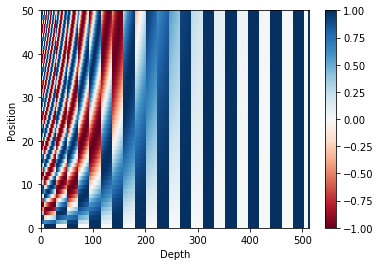

In [34]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [0]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [0]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

### Scaled Dot Product Attention



The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

## Multi-head attention



Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [0]:
class PointWiseFFN(tf.keras.layers.Layer):
  def __init__(self,d_model,dff):
    super(PointWiseFFN,self).__init__()
    self.d_model = d_model
    self.dff = dff

    self.d1 = tf.keras.layers.Dense(dff,activation='relu')
    self.drop = tf.keras.layers.Dropout(0.2)
    self.d2 = tf.keras.layers.Dense(d_model)

  def call(self,x):
    x = self.d1(x)
    x = self.drop(x)
    output = self.d2(x)

    return output



The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = PointWiseFFN(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = PointWiseFFN(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size
                                              ,d_model
                                              ,embeddings_initializer=
                                               tf.keras.initializers.Constant(embeddings_matrixGlove))
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

## 
The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.


In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer
Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, enc_num_layers,dec_num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(enc_num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(dec_num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

# Training

## Set hyperparameters


In [0]:
enc_num_layers = 6
dec_num_layers = 6
d_model = 256
dff = 1024
num_heads = 8

input_vocab_size = len(input_tokenizer.word_index) + 2
target_vocab_size = len(target_tokenizer.word_index) + 2
dropout_rate = 0.1

In [0]:

transformer = Transformer(enc_num_layers,dec_num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

## Optimizer
Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)
optimizerTR = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                      epsilon=1e-9)

#optimizerTR = tf.keras.optimizers.Adam()                                      
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
  name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
  name='val_accuracy')

In [0]:
import shutil

#shutil.rmtree('/content/checkpoints/training_checkpoints_TR_EN')

In [0]:
#os.listdir('/content/drive/My Drive/Master Thesis/Checkpoints')

In [0]:
checkpoint_path = "/content/drive/My Drive/Master Thesis/Checkpoints/training_checkpoints_TR_EN_SUB"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizerTR)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=4)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_stepTR(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizerTR.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

def val_step(inp,tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    predictions, _ = transformer(inp, tar_inp, 
                                 False, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    
    loss = loss_function(tar_real, predictions)
    val_loss(loss)
    val_accuracy(tar_real, predictions)


In [0]:
EPOCHS = 8

In [56]:
_acc = []
_loss = []

_val_acc = []
_val_loss = []

for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()

  val_loss.reset_states()
  val_accuracy.reset_states()
  
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_stepTR(inp, tar)
    
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 4 == 0:
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  _acc.append(train_accuracy.result().numpy())
  _loss.append(train_loss.result().numpy())

  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

  # Run a validation loop at the end of each epoch.
  for batch, (inp,tar) in enumerate(val_dataset):
      val_step(inp,tar)

  _val_acc.append(val_accuracy.result().numpy())
  _val_loss.append(val_loss.result().numpy())
  print('Epoch {} Validation Loss {:.4f} Validation Accuracy {:.4f}\n'.format(epoch + 1, 
                                                val_loss.result(), 
                                                val_accuracy.result()))

Epoch 1 Batch 0 Loss 7.1186 Accuracy 0.0000
Epoch 1 Batch 100 Loss 7.2941 Accuracy 0.0166
Epoch 1 Batch 200 Loss 6.9231 Accuracy 0.0205
Epoch 1 Batch 300 Loss 6.3972 Accuracy 0.0220
Epoch 1 Batch 400 Loss 5.9076 Accuracy 0.0272
Epoch 1 Batch 500 Loss 5.5299 Accuracy 0.0430
Epoch 1 Batch 600 Loss 5.1784 Accuracy 0.0663
Epoch 1 Batch 700 Loss 4.8449 Accuracy 0.0942
Epoch 1 Batch 800 Loss 4.5360 Accuracy 0.1224
Epoch 1 Batch 900 Loss 4.2557 Accuracy 0.1511
Epoch 1 Batch 1000 Loss 4.0103 Accuracy 0.1773
Epoch 1 Batch 1100 Loss 3.7940 Accuracy 0.2014
Epoch 1 Loss 3.7475 Accuracy 0.2066
Time taken for 1 epoch: 729.7462267875671 secs

Epoch 1 Validation Loss 1.4059 Validation Accuracy 0.4780

Epoch 2 Batch 0 Loss 1.2449 Accuracy 0.4777
Epoch 2 Batch 100 Loss 1.4481 Accuracy 0.4753
Epoch 2 Batch 200 Loss 1.4192 Accuracy 0.4760
Epoch 2 Batch 300 Loss 1.3815 Accuracy 0.4812
Epoch 2 Batch 400 Loss 1.3493 Accuracy 0.4861
Epoch 2 Batch 500 Loss 1.3187 Accuracy 0.4916
Epoch 2 Batch 600 Loss 1.2881 A

In [0]:
ckpt_save_path = ckpt_manager.save()


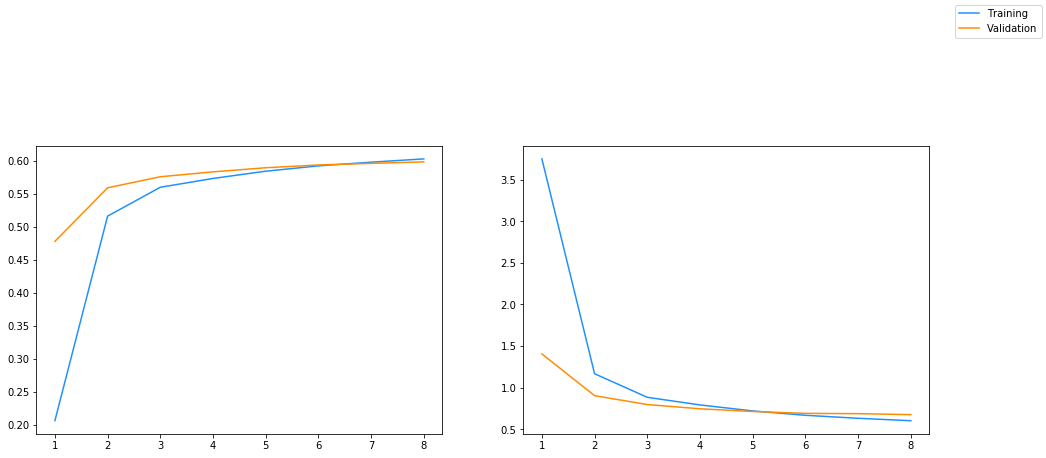

In [58]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1,2,1)

ax.plot(range(1,EPOCHS+1), _acc, color='dodgerblue')
ax.plot(range(1,EPOCHS+1),_val_acc, color='darkorange')

ax1 = fig.add_subplot(1,2,2)

ax1.plot(range(1,EPOCHS+1), _loss, color='dodgerblue')
ax1.plot(range(1,EPOCHS+1),_val_loss, color='darkorange')
fig.legend(['Training', 'Validation'])

plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

## Inference

In [0]:
max_length_inp = pipeline.max_length_inp
max_length_targ = pipeline.max_length_targ


In [0]:
def evaluateTR(sentence):
    sentence = pipeline._preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    encoder_input = tf.convert_to_tensor(inputs)
    
    output = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)

    for i in range(max_length_inp):

      enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
          encoder_input, output)
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(encoder_input, 
                                                  output,
                                                  False,
                                                  enc_padding_mask,
                                                  combined_mask,
                                                  dec_padding_mask)
      

      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
    
      # greedy decoder
      # Argmax for each iteration
      # cast function to reduce dim and get id
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      #predicted_id = tf.cast(tf.random.categorical(predictions[:,-1,:], num_samples=1),tf.int32)
      
      # return the result if the predicted_id is equal to the end token
      if predicted_id == target_tokenizer.word_index['<end>']:
        return tf.squeeze(output, axis=0), attention_weights
      
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [0]:
def takeProbs(elem):
    return elem[0]

In [0]:
def evaluate_beam(sentence,beam_size):
  
  sentence = pipeline._preprocess_sentence(sentence)

  inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
  encoder_input = tf.convert_to_tensor(inputs)
    
  output = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)


  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
    encoder_input, output)

  # predictions.shape == (batch_size, seq_len, vocab_size)
  predictions, attention_weights = transformer(encoder_input, 
                                              output,
                                              False,
                                              enc_padding_mask,
                                              combined_mask,
                                              dec_padding_mask)

  # select the last word from the seq_len dimension
  predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
  # greedy decoder
  # Argmax for each iteration
  # cast function to reduce dim and get id
  predictid_probs , predicted_ids = tf.math.top_k(predictions,k=beam_size)
  candidates = []
  for j in range(beam_size):
    candidates.append((tf.math.log(predictid_probs[:,:,j]),predicted_ids[:,:,j]))
  for i in range(max_length_inp):
    for l in range(len(candidates)): # Cand you loop over tensorlike this
        #all_canidates.remove(candidate)
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, candidates[l][1])

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                      candidates[l][1],
                                                      False,
                                                      enc_padding_mask,
                                                      combined_mask,
                                                      dec_padding_mask)
        predictions = predictions[: ,-1:, :]
        predictid_probs , predicted_ids = tf.math.top_k(predictions,k=beam_size)
        for j in range(beam_size):
          candidates.append((tf.math.add(candidates[l][0],tf.math.log(predictid_probs[:,:,j])),tf.concat([candidates[l][1] ,predicted_ids[:,:,j]],axis=-1)))
          #all_candidates.append((tf.math.add(candidates[l][0],tf.math.log(predictid_probs[:,:,j])),tf.concat([candidates[l][1] ,predicted_ids[:,:,j]],axis=-1)))
    candidates.sort(key=takeProbs)
    candidates = candidates[-beam_size:]


  return tf.squeeze(candidates[-1][1], axis=0), attention_weights

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [0]:
def preprocess_response(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = w.lower().strip()
    w = w.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?').replace(' !','!').replace('<start> ','')
    #w = re.sub(r"([?.!,¿])", r"\1", w)


    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    return w

In [0]:
def plot_attention_weights(attention_weights,inputs,results,layer):
  fig = plt.figure(figsize=(16, 8))

  #sentence = tokenizer_pt.encode(sentence)

  attention = tf.squeeze(attention_weights[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:, :len(inputs)+2], cmap='Blues')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(inputs)+2))
    ax.set_yticks(range(len(results)+1))
    
    ax.set_ylim(len(results)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[i for i in inputs]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([i for i in results if i!='<start>'] , 
                        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  #plt.savefig('/content/drive/My Drive/Master Thesis/transromferAtn.png')
  plt.show()

In [0]:
def respondTR(sentence, plot=''):
  result, attention_weights = evaluateTR(sentence)
  
  predicted_sentence = ' '.join([target_tokenizer.index_word[i] for i in result.numpy() 
                                            if i < len(target_tokenizer.word_index)])


  inputs = [i for i in sentence.split(' ')]
  results = [target_tokenizer.index_word[i] for i in result.numpy()]

  print('Input: {}'.format(sentence))
  print('Predicted Response: {}'.format(preprocess_response(predicted_sentence)))
  
  if plot:
    plot_attention_weights(attention_weights, inputs, results, plot)

In [0]:
def decode_beam_result(result):
  decoded_sentence = []
  for i in result.numpy():
    if i < len(target_tokenizer.word_index):
      decoded_sentence.append(target_tokenizer.index_word[i])
    if target_tokenizer.index_word[i] == '<end>':
      return ' '.join(decoded_sentence)
  return ' '.join(decoded_sentence)

In [0]:
def respond_beam(sentence,beam_size, plot=''):
  result, attention_weights = evaluate_beam(sentence,beam_size)
  
  predicted_sentence = decode_beam_result(result)


  inputs = [i for i in sentence.split(' ')]
  results = [target_tokenizer.index_word[i] for i in result.numpy()]

  print('Input: {}'.format(sentence))
  print('Predicted Response: {}'.format(preprocess_response(predicted_sentence)))
  
  if plot:
    plot_attention_weights(attention_weights, inputs, results, plot)

In [69]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  47735808  
_________________________________________________________________
decoder (Decoder)            multiple                  13816064  
_________________________________________________________________
dense_96 (Dense)             multiple                  7524703   
Total params: 69,076,575
Trainable params: 69,076,575
Non-trainable params: 0
_________________________________________________________________


Input: Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.
Predicted Response: we appreciate you reporting this! i will send an agent from our service team to check it out as soon as possible and let you know if i need further information. did you know that you can send your damage report to damagesca@<company>


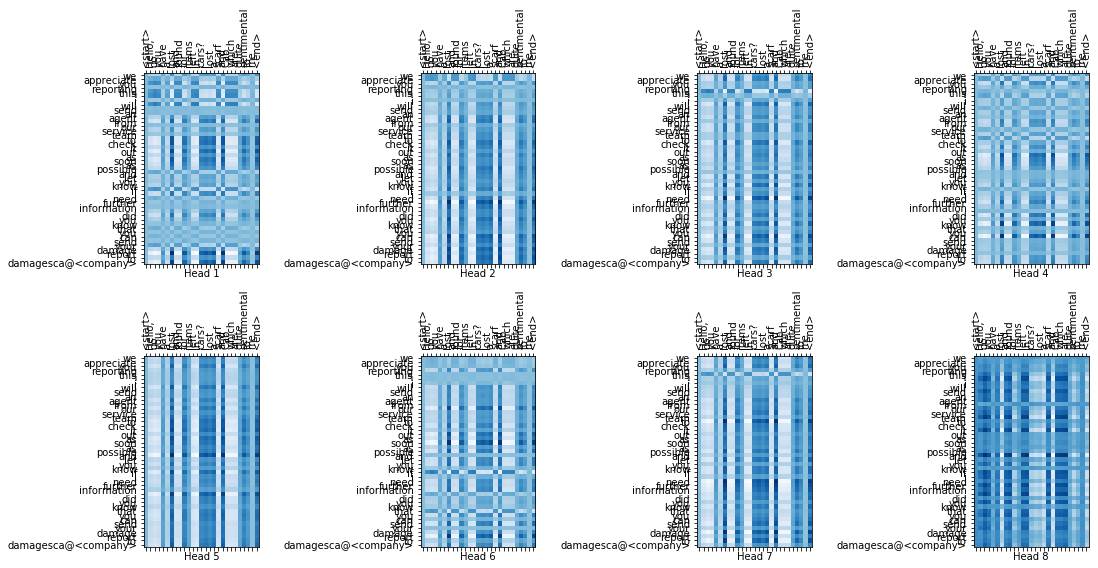

In [70]:
respondTR('Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.',plot='decoder_layer5_block2')

Input: Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.
Predicted Response: we appreciate you taking the time to refuel our vehicle. i’ve reimbursed you in the form of <company> credit


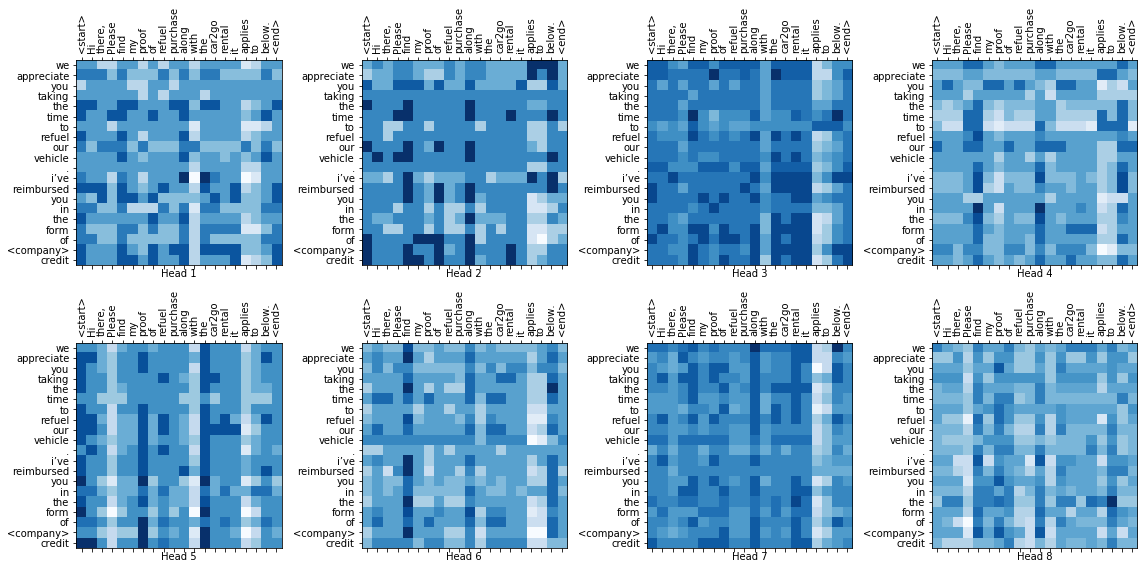

In [71]:
respondTR('Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.',plot='decoder_layer5_block2')

Input: Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.
Predicted Response: we appreciate you taking the time to refuel our vehicle. i’ve reimbursed you in the form of <company> credit


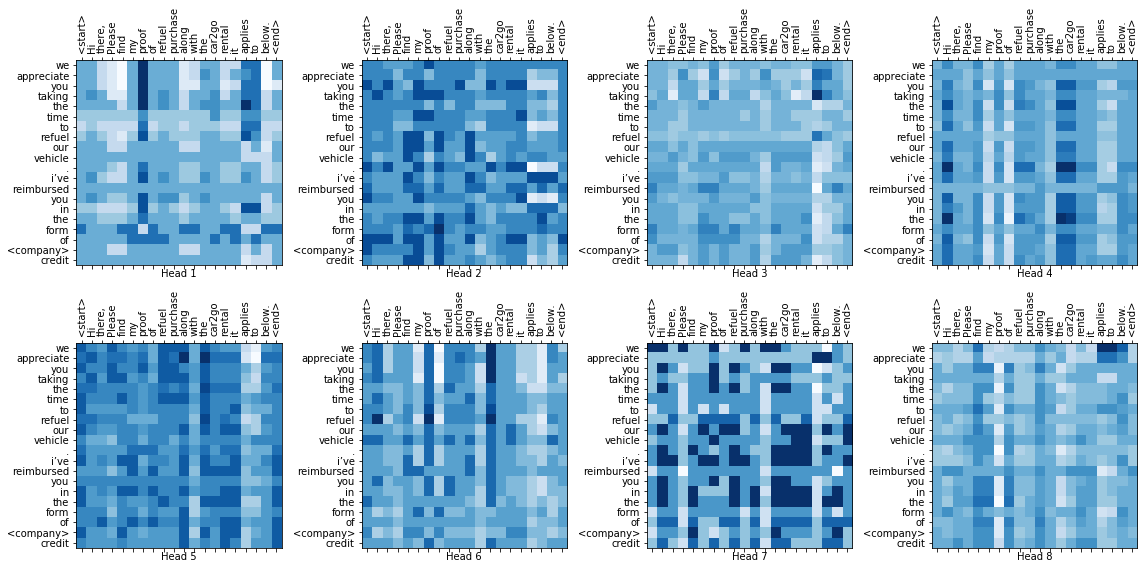

In [72]:
respondTR('Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.',plot='decoder_layer6_block2')

In [73]:
respondTR('Please see attached copy of my drivers license for my Car2Go records.')

Input: Please see attached copy of my drivers license for my Car2Go records.
Predicted Response: i appreciate you sending your photos, however these pictures cannot be uploaded manually and must be scanned on the <company> app. just open the app to access your account and use the license scanning feature to submit pictures of your driver’s license and a selfie


In [74]:
respondTR('Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.')

Input: Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.
Predicted Response: we appreciate you taking the time to refuel our vehicle. i’ve reimbursed you in the form of <company> credit


In [75]:
respondTR('Car rental today vehicle had warning light on that tire sensor was not working')

Input: Car rental today vehicle had warning light on that tire sensor was not working
Predicted Response: we appreciate you reporting this! i will send an agent from our service team to check it out as soon as possible and let you know if i need further information. did you know that you can send your damage report to damagesca@<company>


In [76]:
respond_beam('Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.',2)

Input: Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.
Predicted Response: we kindly ask that you change it in your account by following these simple steps: access our website log in to your account in the section: my details, edit the field “e-mail if you have any additional questions or concerns, please don't hesitate to let me know <end>


In [77]:
respondTR('Why am I not able to end my rental?')

Input: Why am I not able to end my rental?
Predicted Response: we appreciate you taking the time to refuel our vehicle. i’ve reimbursed you in the form of <company> credit


In [78]:
respond_beam('Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.',2)

Input: Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.
Predicted Response: we kindly ask that you change it in your account by following these simple steps: access our website log in to your account in the section: my details, edit the field “e-mail if you have any additional questions or concerns, please don't hesitate to let me know <end>


- Please cancel my account and remove all credit card information from your system.
- Please see attached copy of my drivers license for my Car2Go records.
- Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.
- Car rental today - vehicle had warning light on that tire sensor was not working
- Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.
- Why am I not able to end my rental?

In [0]:
def preprocess_response(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = w.lower().strip()
    w = w.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?').replace(' !','!')
    #w = re.sub(r"([?.!,¿])", r"\1", w)
    
    w = w.replace('<start> ','').replace(' <end>','')
    w = w.rstrip().strip()
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    return w

In [0]:
def get_response(output):
  #output: numpay array containing predicted word ids
  return  preprocess_response(' '.join([target_tokenizer.index_word[i] for i in output
                                            if i < len(target_tokenizer.word_index)]))
  
def get_response_beam(output):
  #output: numpay array containing predicted word ids
  decoded_sentence = []
  for i in output:
    if i < len(target_tokenizer.word_index):
      decoded_sentence.append(target_tokenizer.index_word[i])
    if target_tokenizer.index_word[i] == '<end>':
      return ' '.join(decoded_sentence)
  return ' '.join(decoded_sentence)

def get_input(input):
  #input: numpy array of ids of input
  return  preprocess_response(' '.join([input_tokenizer.index_word[i] for i in input
                                            if (i < len(input_tokenizer.word_index))
                                            & (i !=0) ]))
def get_truth(target):
  #target: numpy array of ids of actual response
  return  preprocess_response(' '.join([target_tokenizer.index_word[i] for i in target
                                            if (i < len(target_tokenizer.word_index))
                                            & (i !=0) ]))

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [0]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
calc_rouge = Rouge()


chencherry = nltk.translate.bleu_score.SmoothingFunction()

In [0]:
def run_inference_greedy(test_dataset,transformer):

 
  test_enquiries = []
  bot_respones = []
  true_responses = []


  for (batch, (inpt, targt)) in enumerate(test_dataset):
      encoder_input =  inpt

      #encoder_input = encoder_input[:, :-1]

    
      if batch % 5 == 0:
        print ('Batch {} '.format(batch))
      # as the target is english, the first word to the transformer should be the
      # english start token.
      #output = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)
      output = tf.constant(np.repeat([target_tokenizer.word_index['<start>']],inpt.shape[0]),shape=(inpt.shape[0],1),dtype=tf.int32)
      #output = tf.expand_dims(output, 0)
        
      for i in range(max_length_targ):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
      
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    combined_mask,
                                                    dec_padding_mask)
        
        #temperature = 0.3
        predictions = predictions #/ temperature
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        output = tf.concat([output, predicted_id], axis=-1)
        
      [bot_respones.append(get_response(x)) for x in output.numpy()]
      [true_responses.append(get_truth(x)) for x in targt.numpy()]
      [test_enquiries.append(get_input(x)) for x in inpt.numpy()]

  bleus = []
  meteors = []
  rouges  = []
  for (a,b) in zip(bot_respones,true_responses):
    bleus.append(sentence_bleu([b.split(' ')],
                                  a.split(' '),smoothing_function=chencherry.method1))

    meteors.append(meteor_score([b],a))
    scores = calc_rouge.get_scores(b,a)
    rouges.append(scores[0]['rouge-1']['f'])

  df_result = pd.DataFrame({'BLEU':bleus,'ROUGE-1':rouges,'METEOR':meteors,'Enquiry':test_enquiries,'Bot':bot_respones,'True':true_responses})


  return df_result

In [0]:
def run_inference_beam(test_dataset,beam_size):
  test_enquiries = []
  bot_respones = []
  true_responses = []


  for (batch, (inpt, targt)) in enumerate(test_dataset):
      encoder_input =  inpt

      #encoder_input = encoder_input[:, :-1]

    
      if batch % 100 == 0:
        print ('Batch {} '.format(batch))
      # as the target is english, the first word to the transformer should be the
      # english start token.
      #output = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)
      output = tf.constant(np.repeat([target_tokenizer.word_index['<start>']],inpt.shape[0]),shape=(inpt.shape[0],1),dtype=tf.int32)

      enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
      encoder_input, output)

      predictions, attention_weights = transformer(encoder_input, 
                                                output,
                                                False,
                                                enc_padding_mask,
                                                combined_mask,
                                                dec_padding_mask)

      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predictid_probs , predicted_ids = tf.math.top_k(predictions,k=beam_size)

      candidates = []
      for j in range(beam_size):
        candidates.append(predicted_ids[:,:,j])
        if j == 0:
          probs = tf.math.log(predictid_probs[:,:,0])
        else:
          probs = tf.concat([probs,tf.math.log(predictid_probs[:,:,j])],axis=1)


      for i in range(max_length_inp):
        for l in range(len(candidates)): # Cand you loop over tensorlike this
          #all_canidates.remove(candidate)
          enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
             encoder_input, candidates[l])

          # predictions.shape == (batch_size, seq_len, vocab_size)
          predictions, attention_weights = transformer(encoder_input, 
                                                      candidates[l],
                                                      False,
                                                      enc_padding_mask,
                                                      combined_mask,
                                                      dec_padding_mask)
          # [:,-1:,:] get the last prediction
          predictions = predictions[: ,-1:, :]
          predictid_probs , predicted_ids = tf.math.top_k(predictions,k=beam_size)
          for j in range(beam_size):
            candidates.append(tf.concat([candidates[l],predicted_ids[:,:,j]],axis=1))
            probs = tf.concat([probs, tf.math.add(tf.reshape(probs[:,l],shape=(inpt.shape[0],1)),tf.math.log(predictid_probs[:,:,j]))],axis=1)
        new_candidates = []
        probs , top_ids = tf.math.top_k(probs,k=beam_size)
        for k in range(beam_size):
          result_array = np.empty((0, candidates[l].shape[1]+1))
          for _row,idx in enumerate(top_ids.numpy()):
            result_array = np.append(result_array,[candidates[idx[k]].numpy()[_row]],axis=0)
          result_tensor = tf.convert_to_tensor(result_array,dtype=tf.int32)
          new_candidates.append(result_tensor)
        candidates = new_candidates
   

      [bot_respones.append(get_response_beam(x)) for x in candidates[0].numpy()]
      [true_responses.append(get_truth(x)) for x in targt.numpy()]
      [test_enquiries.append(get_input(x)) for x in inpt.numpy()]      

  bleus = []
  meteors = []
  rouges  = []
  for (a,b) in zip(bot_respones,true_responses):
    bleus.append(sentence_bleu([b.split(' ')],
                                  a.split(' '),smoothing_function=chencherry.method1))

    meteors.append(meteor_score([b],a))
    scores = calc_rouge.get_scores(b,a)
    rouges.append(scores[0]['rouge-1']['f'])

  df_result = pd.DataFrame({'BLEU':bleus,'ROUGE-1':rouges,'METEOR':meteors,'Enquiry':test_enquiries,'Bot':bot_respones,'True':true_responses})

  return df_result

In [84]:
df_result = run_inference_greedy(test_dataset,transformer)


Batch 0 
Batch 5 
Batch 10 
Batch 15 
Batch 20 
Batch 25 
Batch 30 
Batch 35 
Batch 40 
Batch 45 
Batch 50 
Batch 55 
Batch 60 
Batch 65 
Batch 70 
Batch 75 
Batch 80 
Batch 85 
Batch 90 
Batch 95 
Batch 100 
Batch 105 
Batch 110 
Batch 115 
Batch 120 
Batch 125 
Batch 130 
Batch 135 
Batch 140 
Batch 145 
Batch 150 
Batch 155 
Batch 160 
Batch 165 
Batch 170 
Batch 175 
Batch 180 
Batch 185 
Batch 190 
Batch 195 
Batch 200 
Batch 205 
Batch 210 
Batch 215 
Batch 220 
Batch 225 
Batch 230 
Batch 235 
Batch 240 
Batch 245 
Batch 250 
Batch 255 
Batch 260 
Batch 265 
Batch 270 
Batch 275 
Batch 280 
Batch 285 
Batch 290 
Batch 295 
Batch 300 
Batch 305 
Batch 310 
Batch 315 
Batch 320 
Batch 325 
Batch 330 
Batch 335 
Batch 340 
Batch 345 
Batch 350 


In [0]:
df_test.to_csv('/content/drive/My Drive/Master Thesis/Results/Transformer.csv')

In [0]:
df_result[['BLEU','ROUGE-1','METEOR']].mean()

In [0]:
def clean_classification(x):
  try:
    return re.sub(r"[^a-zA-Z&; ]+", "",x).replace('deleted','').replace('cargo','<company>').strip(' ')
  except:
    return x
    
    
data['CLASSIFICATIONS'] = [clean_classification(x) for x in data['CLASSIFICATIONS_x']]

In [0]:
  def preprocess_sentence(w,is_input=False):
      #w = unicode_to_ascii(w.lower().strip())

      # creating a space between a word and the punctuation following it
      # eg: "he is a boy." => "he is a boy ."
      # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
      w = w.lower().strip()
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)
      w = w.replace('\n', ' ').replace('\r', ' ').replace('\xa0',' ')
      if is_input == True:
      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,0-9]+", " ", w)
      w = w.replace('car2go','<company>')
      w = w.replace('Share Now','<company>')

      w = w.rstrip().strip()

      # adding a start and an end token to the sentence
      # so that the model know when to start and stop predicting.
      w = '<start> ' + w + ' <end>'
      return w


  def tokenize(corpus,tokenizer):
   
      tensor = tokenizer.texts_to_sequences(corpus)
      #tensor = [len(tokenizer.word_index)] + tensor + [len(tokenizer.word_index + 1)]
      #tensor = tf.convert_to_tensor(tensor)
      tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                            padding='post',
                                                            maxlen=MAX_LENGTH)

      return tensor


  def get_training_data(inputs,targets):   
      enquiries = [preprocess_sentence(x,True) for x in inputs]
      replies = [preprocess_sentence(x) for x in targets]

      input_tensor = tokenize(enquiries,input_tokenizer)
      target_tensor = tokenize(replies,target_tokenizer)

      input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2)
      
      train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(len(input_tensor_train))
            
      test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(len(input_tensor_test))

      return test_dataset

In [0]:
class_results = {}
for c in data['CLASSIFICATIONS'].value_counts()[:7].index:

  _test_dataset = get_training_data(inputs=data.loc[data['CLASSIFICATIONS']==c,'enquiry'].to_list()
                                        ,targets = data.loc[data['CLASSIFICATIONS']==c,'reply'].to_list())
  _test_dataset = _test_dataset.batch(BATCH_SIZE,drop_remainder=True)
  test_results = run_inference_greedy(_test_dataset,transformer)
  class_results.update({c : test_results[['BLEU','ROUGE-1','METEOR']]})

In [0]:
for c in class_results.keys():
  print(c+'\n',class_results[c].mean())